# PCA on Labeled Faces in the Wild

In [1]:
import numpy as np
import tueplots.constants.color.rgb as rgb
from matplotlib import pyplot as plt
from matplotlib import ticker
from tueplots import bundles, fontsizes

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update(fontsizes.from_base(base=10))

First, load the data: (You can find the data on Ilias in the Exercise Folder for Ex Sheet 08).

In [ ]:
import os

import tqdm

N = 13232
P = 49 * 36
dim = (49, 36)

X = np.zeros([N, P])

for i in tqdm.trange(N, miniters=100):
    img = np.loadtxt(f"../../04_notebooks/Fair-PCA/data/images/img{i}.txt").ravel()
    X[i] = img

print(X.shape)

Xmean = np.mean(X, axis=0)
X -= Xmean

sex = np.loadtxt("../../04_notebooks/Fair-PCA/data/images/sex.txt")

F = X[(sex == 0), :]  # labeled female
M = X[(sex == 1), :]  # labeled male

NF = F.shape[0]
NM = M.shape[0]

 15%|█▌        | 2000/13232 [00:04<00:18, 622.08it/s]

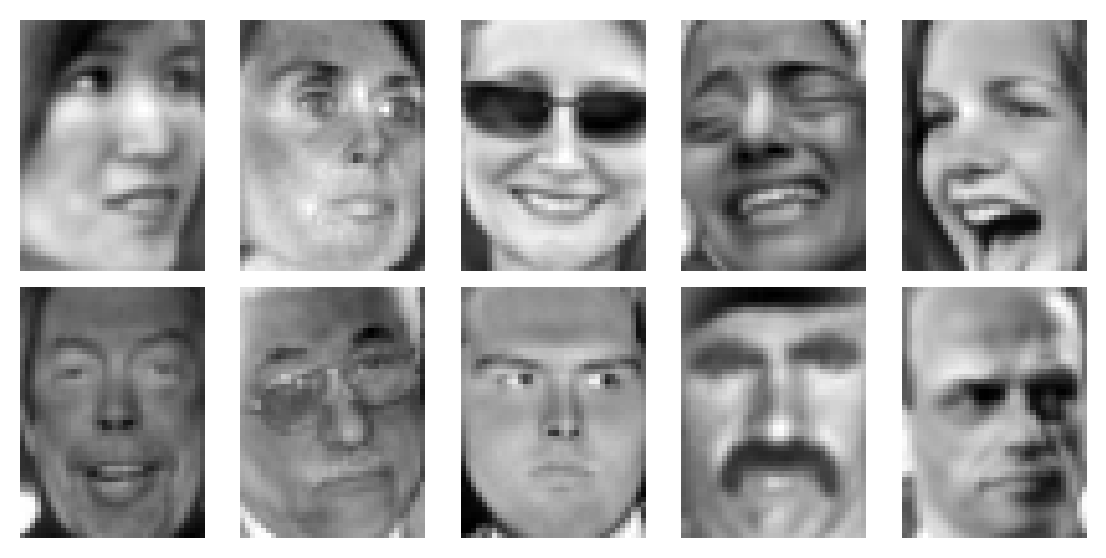

In [3]:
# some exploration of the dataset:

fig, ax = plt.subplots(2, 5, dpi=200)
for i in np.arange(5):
    ax[0, i].imshow(F[i, :].reshape(dim), cmap="gray")
    ax[1, i].imshow(M[i, :].reshape(dim), cmap="gray")
    ax[0,i].axis('off')
    ax[1,i].axis('off')

Now, PCA:

In [4]:
Q,D,Uh = np.linalg.svd(X)

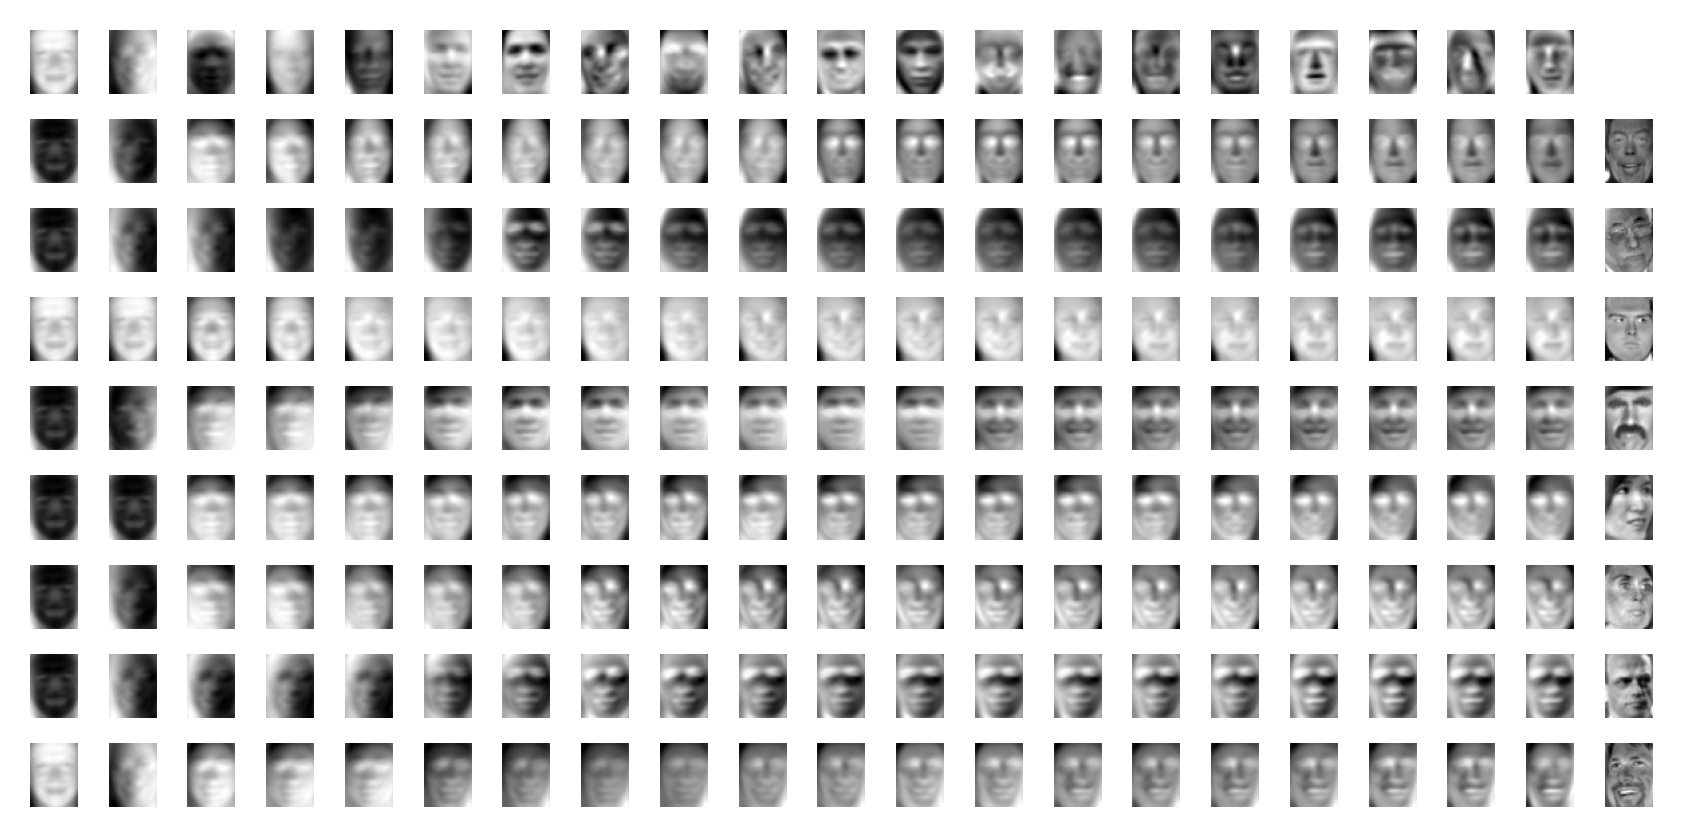

In [5]:
# let's compute some projection errors
n = 8
p = 20
fig,ax = plt.subplots(n+1,p+1,dpi=300)

firstimages = X[:n,:]

for j in np.arange(p):
    ax[0,j].imshow(Uh[j,:].reshape(dim),cmap='gray')
    
for i in np.arange(n):
    ax[i+1,p].imshow(firstimages[i,:].reshape(dim),cmap='gray')

    for j in np.arange(p):
        ax[i+1,j].imshow(((firstimages[i,:] @ Uh.T[:,:j+1]) @ Uh[:j+1,:]).reshape(dim),cmap='gray')
    
for i in np.arange(n+1):
    for j in np.arange(p+1):
        ax[i,j].axis('off')

What is the reconstruction error?

In [6]:
Projected_X = X @ Uh.T
Projected_M = M @ Uh.T
Projected_F = F @ Uh.T

T = 20
ARE_X = np.zeros(T)
ARE_M = np.zeros(T)
ARE_F = np.zeros(T)

for i in tqdm.trange(T):
    ARE_X[i] = ((X - Projected_X[:,:i+1] @ Uh[:i+1,:])**2).sum().sum() / N / P
    ARE_M[i] = ((M - Projected_M[:,:i+1] @ Uh[:i+1,:])**2).sum().sum() / NM / P
    ARE_F[i] = ((F - Projected_F[:,:i+1] @ Uh[:i+1,:])**2).sum().sum() / NF / P

100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


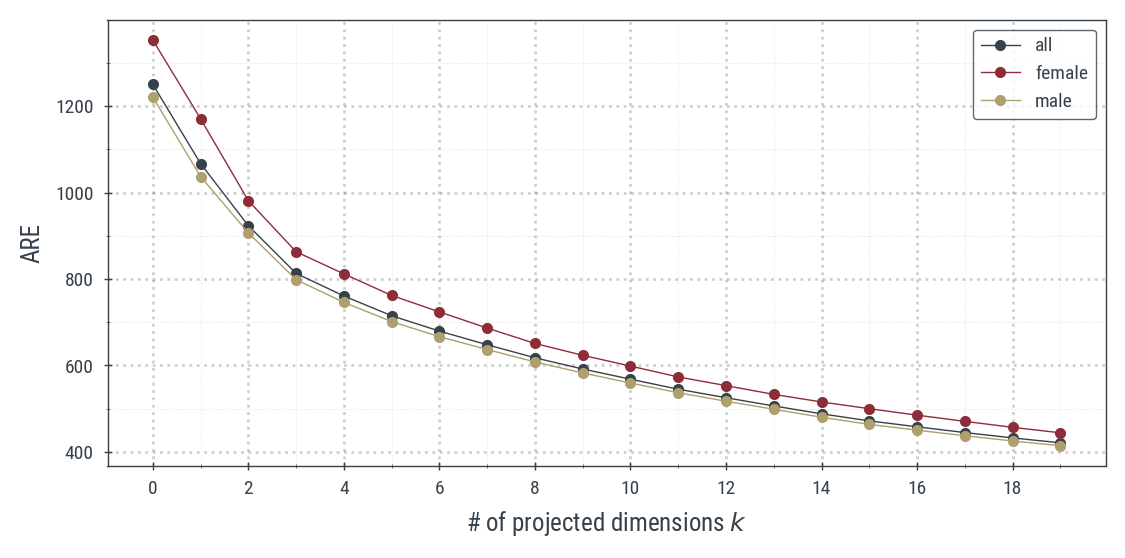

In [11]:
fig,ax = plt.subplots(1,1,dpi=200)

ax.plot(np.arange(T),ARE_X,'o-',color=rgb.tue_dark,ms=3,label='all')
ax.plot(np.arange(T),ARE_F,'o-',color=rgb.tue_red,ms=3,label='female')
ax.plot(np.arange(T),ARE_M,'o-',color=rgb.tue_gold,ms=3,label='male')

ax.legend(loc='upper right')

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.grid(axis='both',which='major',linewidth=1)
ax.grid(axis='both',which='minor',linewidth=.2)

ax.set_ylabel('ARE')
ax.set_xlabel('# of projected dimensions $k$');

Is this perhaps due to the different sizes of each group?

In [12]:
print(f"There are {NM} male and {NF} female faces in the dataset")

There are 10270 male and 2962 female faces in the dataset


In [13]:
M_clipped = M[:NF,:]

Xclipped = np.vstack([M_clipped,F])

Qc,Dc,Uch = np.linalg.svd(Xclipped)

Proj_clipped_X = Xclipped @ Uch.T
Proj_clipped_M = M_clipped @ Uch.T
Proj_clipped_F = F @ Uch.T

T = 20
ARE_Xc = np.zeros(T)
ARE_Mc = np.zeros(T)
ARE_Fc = np.zeros(T)

for i in tqdm.trange(T):
    ARE_Xc[i] = ((Xclipped - Proj_clipped_X[:,:i+1] @ Uch[:i+1,:])**2).sum().sum() / (2*NF) / P
    ARE_Mc[i] = ((M_clipped - Proj_clipped_M[:,:i+1] @ Uch[:i+1,:])**2).sum().sum() / NF / P
    ARE_Fc[i] = ((F - Proj_clipped_F[:,:i+1] @ Uch[:i+1,:])**2).sum().sum() / NF / P

100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


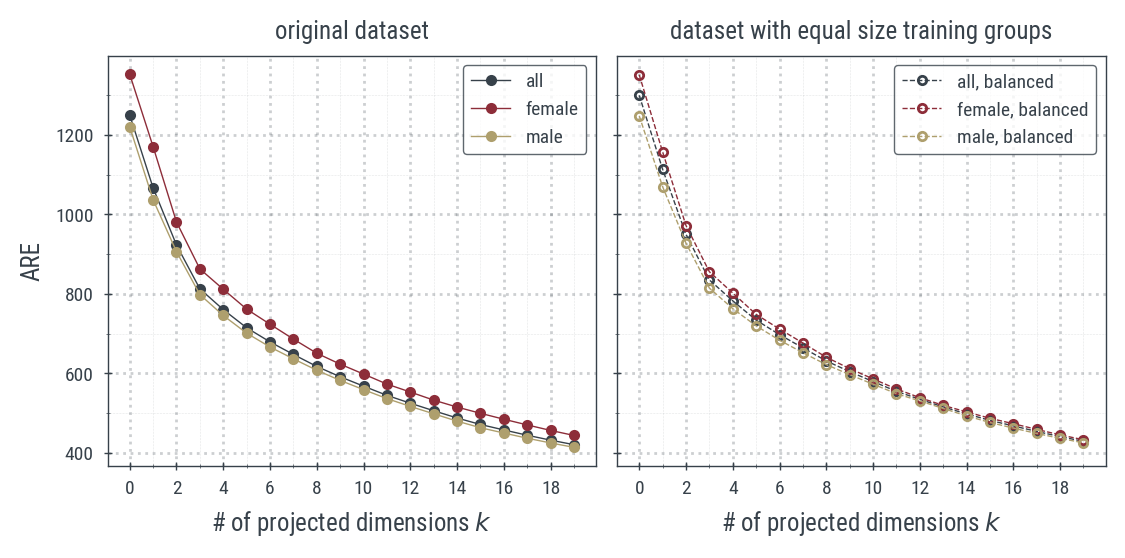

In [14]:
fig,ax = plt.subplots(1,2,dpi=200,sharey=True)

ax[0].plot(np.arange(T),ARE_X,'o-',color=rgb.tue_dark,ms=3,label='all')
ax[0].plot(np.arange(T),ARE_F,'o-',color=rgb.tue_red,ms=3,label='female')
ax[0].plot(np.arange(T),ARE_M,'o-',color=rgb.tue_gold,ms=3,label='male')

ax[1].plot(np.arange(T),ARE_Xc,'o--',color=rgb.tue_dark,ms=3,mfc='none',label='all, balanced')
ax[1].plot(np.arange(T),ARE_Fc,'o--',color=rgb.tue_red,ms=3,mfc='none',label='female, balanced')
ax[1].plot(np.arange(T),ARE_Mc,'o--',color=rgb.tue_gold,ms=3,mfc='none',label='male, balanced')

for i in np.arange(2):
    ax[i].legend(loc='upper right')

    ax[i].xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(1))

    ax[i].yaxis.set_major_locator(ticker.MultipleLocator(200))
    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(100))
    ax[i].grid(axis='both',which='major',linewidth=1)
    ax[i].grid(axis='both',which='minor',linewidth=.2)

    ax[0].set_ylabel('ARE')
    ax[i].set_xlabel('# of projected dimensions $k$')

ax[0].set_title('original dataset')
ax[1].set_title('dataset with equal size training groups');

Which images are badly compressed, and which are best compressed?

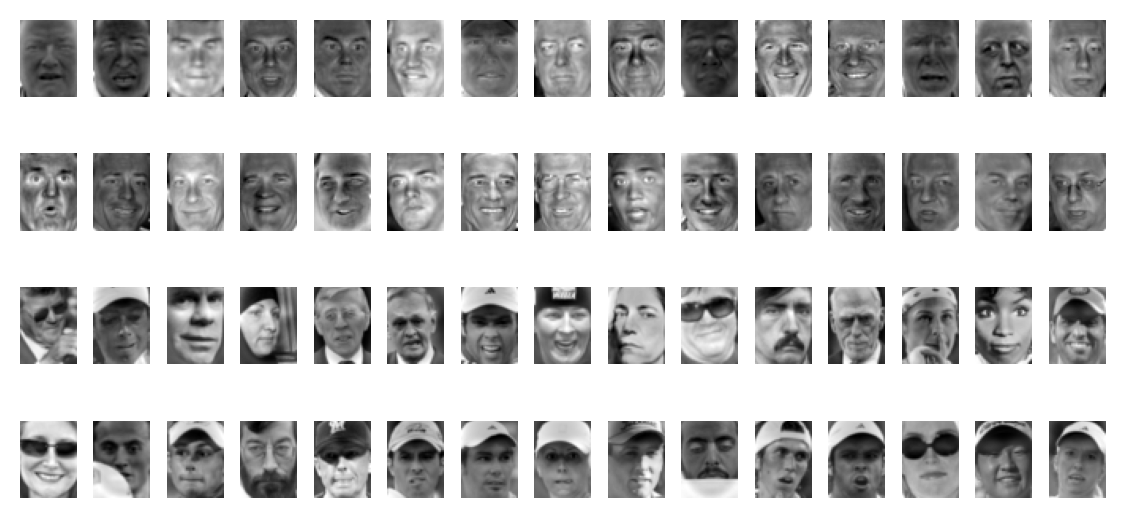

In [15]:
# let's check images projected onto the first two principal components:
T = 5
ARE_T = ((X - Projected_X[:,:T+1] @ Uh[:T+1,:])**2).sum(axis=1)
X_by_ARE = X[np.argsort(ARE_T),:]

fig,ax = plt.subplots(4,15,dpi=200)
for i in np.arange(15):
    ax[0,i].imshow(X_by_ARE[i,:].reshape(dim),cmap='gray')
    ax[1,i].imshow(X_by_ARE[i+15,:].reshape(dim),cmap='gray')
    
    ax[2,i].imshow(X_by_ARE[N-2*15+i,:].reshape(dim),cmap='gray')
    ax[3,i].imshow(X_by_ARE[N-15+i,:].reshape(dim),cmap='gray')

for i in range(4):
    for j in range(15):
        ax[i,j].axis('off')

Some statistics of the images.

In [16]:
from scipy.stats import skew, kurtosis

X_means = X.mean(axis=1)
M_means = M.mean(axis=1)
F_means = F.mean(axis=1)

X_stds = np.std(X,axis=1)
M_stds = np.std(M,axis=1)
F_stds = np.std(F,axis=1)

X_skew = skew(X,axis=1)
M_skew = skew(M,axis=1)
F_skew = skew(F,axis=1)

X_kurt = kurtosis(X,axis=1)
M_kurt = kurtosis(M,axis=1)
F_kurt = kurtosis(F,axis=1)

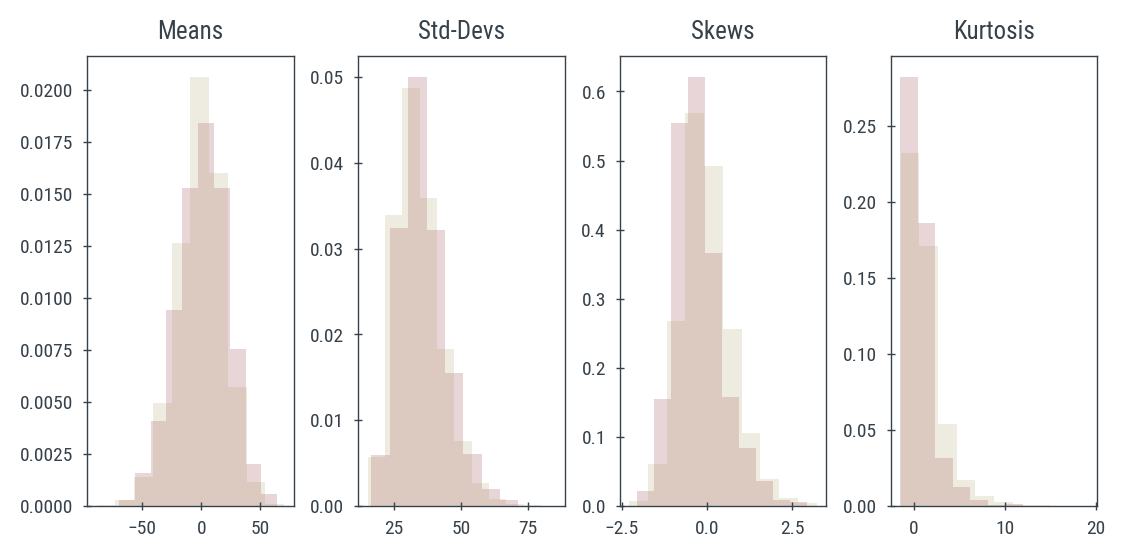

In [17]:
fig,ax = plt.subplots(1,4,dpi=200)

ax[0].set_title('Means')
# ax[0].hist(X_means,color=rgb.tue_dark,alpha=0.2,density=True);
ax[0].hist(F_means,color=rgb.tue_red,alpha=0.2,density=True);
ax[0].hist(M_means,color=rgb.tue_gold,alpha=0.2,density=True);

ax[1].set_title('Std-Devs')
# ax[1].hist(X_stds,color=rgb.tue_dark,alpha=0.2,density=True);
ax[1].hist(F_stds,color=rgb.tue_red,alpha=0.2,density=True);
ax[1].hist(M_stds,color=rgb.tue_gold,alpha=0.2,density=True);

ax[2].set_title('Skews')
# ax[2].hist(X_skew,color=rgb.tue_dark,alpha=0.2,density=True);
ax[2].hist(F_skew,color=rgb.tue_red,alpha=0.2,density=True);
ax[2].hist(M_skew,color=rgb.tue_gold,alpha=0.2,density=True);

ax[3].set_title('Kurtosis')
# ax[3].hist(X_kurt,color=rgb.tue_dark,alpha=0.2,density=True);
ax[3].hist(F_kurt,color=rgb.tue_red,alpha=0.2,density=True);
ax[3].hist(M_kurt,color=rgb.tue_gold,alpha=0.2,density=True);

how about we whiten each image, separately? (This requires storing the extra two "pixels" `X_means` and `X_stds`)

In [18]:
X0 = (X - X_means[:,np.newaxis]) / X_stds[:,np.newaxis]
X0mean = X0.mean(axis=0)

# now we do PCA again:

X0 -= X0mean

Q0,D0,U0h = np.linalg.svd(X0)

In [19]:
F0 = X0[(sex == 0), :]  # labeled female
M0 = X0[(sex == 1), :]  # labeled male

Projected_X0 = X0 @ U0h.T
Projected_M0 = M0 @ U0h.T
Projected_F0 = F0 @ U0h.T

T = 20
ARE_X0 = np.zeros(T)
ARE_M0 = np.zeros(T)
ARE_F0 = np.zeros(T)

for i in tqdm.trange(T):
    ARE_X0[i] = ((X0 - Projected_X0[:,:i+1] @ U0h[:i+1,:])**2).sum().sum() / N / P
    ARE_M0[i] = ((M0 - Projected_M0[:,:i+1] @ U0h[:i+1,:])**2).sum().sum() / NM / P
    ARE_F0[i] = ((F0 - Projected_F0[:,:i+1] @ U0h[:i+1,:])**2).sum().sum() / NF / P

100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


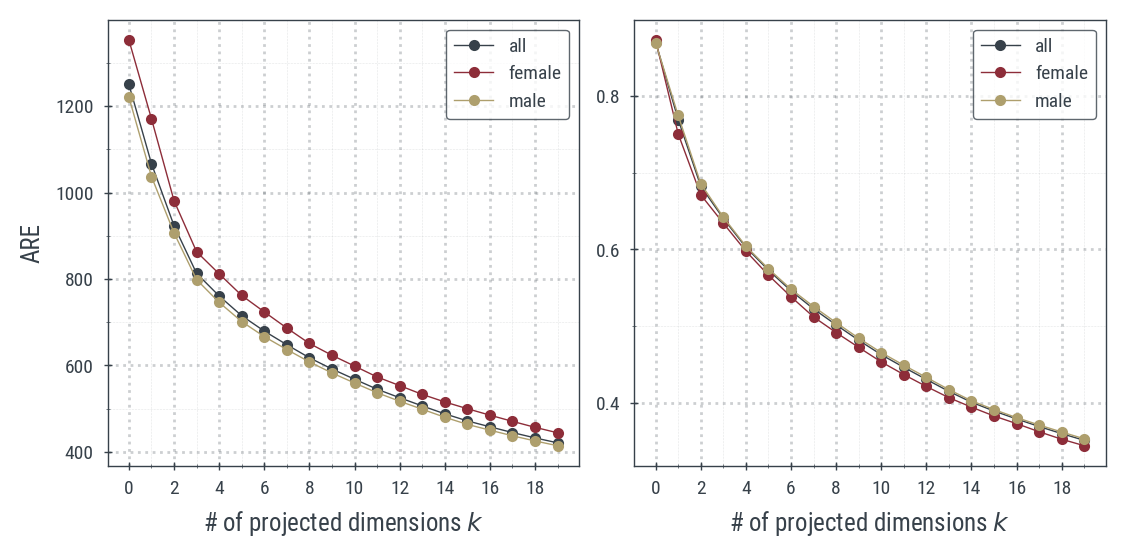

In [20]:
fig,ax = plt.subplots(1,2,dpi=200)

ax[0].plot(np.arange(T),ARE_X,'o-',color=rgb.tue_dark,ms=3,label='all')
ax[0].plot(np.arange(T),ARE_F,'o-',color=rgb.tue_red,ms=3,label='female')
ax[0].plot(np.arange(T),ARE_M,'o-',color=rgb.tue_gold,ms=3,label='male')

ax[1].plot(np.arange(T),ARE_X0,'o-',color=rgb.tue_dark,ms=3,label='all')
ax[1].plot(np.arange(T),ARE_F0,'o-',color=rgb.tue_red,ms=3,label='female')
ax[1].plot(np.arange(T),ARE_M0,'o-',color=rgb.tue_gold,ms=3,label='male')

ax[0].set_ylabel('ARE')
for axi in plt.gcf().get_axes():
    axi.legend(loc='upper right')
    axi.set_xlabel('# of projected dimensions $k$')
    axi.grid(axis='both',which='major',linewidth=1)
    axi.grid(axis='both',which='minor',linewidth=.2)
    
    axi.xaxis.set_major_locator(ticker.MultipleLocator(2))
    axi.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax[0].yaxis.set_major_locator(ticker.MultipleLocator(200))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(100))

ax[1].yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
